In [296]:
import numpy as np 
import pandas as pd
from numpy import load

import matplotlib.pyplot as plt
from matplotlib import cm 
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
from tensorflow.keras import regularizers, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
import time, cv2
from IPython.display import Image, display

#classification
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB3, EfficientNetB7, decode_predictions

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools

from sklearn import metrics

import seaborn as sns

In [297]:
#chargement de X_brain et y_brain
np.load.__defaults__=(None, True, True, 'ASCII')

X_brain= load('Documents/projet-hemorragie/data-source/outputs/X_brain_256.npy')
y_brain = load('Documents/projet-hemorragie/data-source/outputs/y_brain.npy')
X_mask = load('Documents/projet-hemorragie/data-source/outputs/X_mask_256.npy')

# Shape de X_brain et y_brain
print('Shape of X_brain:', X_brain.shape)
print('Shape of y_brain:',y_brain.shape)
print('Shape of X_mask_150:',X_mask.shape)

Shape of X_brain: (2501, 256, 256, 3)
Shape of y_brain: (2501,)
Shape of X_mask_150: (2501, 256, 256)


In [298]:
### split des données ###

X_train, X_test, y_train, y_test = train_test_split(X_brain, y_brain, test_size=0.2, random_state=1)

#456 nul
#12345 nul
#124 nul
#456 nul
# 1 c'est le mieux pour le moment

# Shape de X_train et y_train
print('Shape of X:', X_train.shape)
print('Shape of y:',y_train.shape)

Shape of X: (2000, 256, 256, 3)
Shape of y: (2000,)


In [299]:
# EFFICIENTNET

BATCH_SIZE = 32

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_dataset = train_datagen.flow(X_train,y_train,
                         batch_size = BATCH_SIZE)

test_dataset = test_datagen.flow(X_test, y_test,
                         batch_size = BATCH_SIZE)

In [300]:
input_model = Input([None,None,3])

# Modèle Efficientnet-B3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_model) 

# Freezer les couches du Efficientnet-B3
for layer in base_model.layers: 
    layer.trainable = False
    
x = GlobalAveragePooling2D()(base_model.output) 
x = Dense(1024,activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs = base_model.inputs, outputs=x)

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = {i:w for i,w in enumerate(class_weights)}

model.compile(loss = "binary_crossentropy",
              optimizer = Adam(lr=1e-4),
              metrics = ["accuracy"])

/Users/johannambrugeat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [301]:
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_32 (Rescaling)       (None, None, None,   0           ['input_17[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_16 (Normalizatio  (None, None, None,   7          ['rescaling_32[0][0]']           
 n)                             3)                                                         

                                                                                                  
 block1b_add (Add)              (None, None, None,   0           ['block1b_drop[0][0]',           
                                24)                               'block1a_project_bn[0][0]']     
                                                                                                  
 block2a_expand_conv (Conv2D)   (None, None, None,   3456        ['block1b_add[0][0]']            
                                144)                                                              
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, None, None,   576        ['block2a_expand_conv[0][0]']    
 ization)                       144)                                                              
                                                                                                  
 block2a_e

                                32)                               'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_expand_conv (Conv2D)   (None, None, None,   6144        ['block2b_add[0][0]']            
                                192)                                                              
                                                                                                  
 block2c_expand_bn (BatchNormal  (None, None, None,   768        ['block2c_expand_conv[0][0]']    
 ization)                       192)                                                              
                                                                                                  
 block2c_expand_activation (Act  (None, None, None,   0          ['block2c_expand_bn[0][0]']      
 ivation)                       192)                                                              
          

 block3b_expand_conv (Conv2D)   (None, None, None,   13824       ['block3a_project_bn[0][0]']     
                                288)                                                              
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   1152       ['block3b_expand_conv[0][0]']    
 ization)                       288)                                                              
                                                                                                  
 block3b_expand_activation (Act  (None, None, None,   0          ['block3b_expand_bn[0][0]']      
 ivation)                       288)                                                              
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, None, None,   7200       ['block3b_expand_activation[0][0]
 D)       

                                                                                                  
 block4a_expand_conv (Conv2D)   (None, None, None,   13824       ['block3c_add[0][0]']            
                                288)                                                              
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, None, None,   1152       ['block4a_expand_conv[0][0]']    
 ization)                       288)                                                              
                                                                                                  
 block4a_expand_activation (Act  (None, None, None,   0          ['block4a_expand_bn[0][0]']      
 ivation)                       288)                                                              
                                                                                                  
 block4a_d

                                576)                                                              
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, None, None,   2304       ['block4c_expand_conv[0][0]']    
 ization)                       576)                                                              
                                                                                                  
 block4c_expand_activation (Act  (None, None, None,   0          ['block4c_expand_bn[0][0]']      
 ivation)                       576)                                                              
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, None, None,   5184       ['block4c_expand_activation[0][0]
 D)                             576)                             ']                               
          

 block4e_expand_conv (Conv2D)   (None, None, None,   55296       ['block4d_add[0][0]']            
                                576)                                                              
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, None, None,   2304       ['block4e_expand_conv[0][0]']    
 ization)                       576)                                                              
                                                                                                  
 block4e_expand_activation (Act  (None, None, None,   0          ['block4e_expand_bn[0][0]']      
 ivation)                       576)                                                              
                                                                                                  
 block4e_dwconv (DepthwiseConv2  (None, None, None,   5184       ['block4e_expand_activation[0][0]
 D)       

                                                                                                  
 block5b_expand_activation (Act  (None, None, None,   0          ['block5b_expand_bn[0][0]']      
 ivation)                       816)                                                              
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, None, None,   20400      ['block5b_expand_activation[0][0]
 D)                             816)                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, None, None,   3264       ['block5b_dwconv[0][0]']         
 )                              816)                                                              
                                                                                                  
 block5b_a

 ization)                       816)                                                              
                                                                                                  
 block5d_expand_activation (Act  (None, None, None,   0          ['block5d_expand_bn[0][0]']      
 ivation)                       816)                                                              
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, None, None,   20400      ['block5d_expand_activation[0][0]
 D)                             816)                             ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, None, None,   3264       ['block5d_dwconv[0][0]']         
 )                              816)                                                              
          

 block6a_expand_bn (BatchNormal  (None, None, None,   3264       ['block6a_expand_conv[0][0]']    
 ization)                       816)                                                              
                                                                                                  
 block6a_expand_activation (Act  (None, None, None,   0          ['block6a_expand_bn[0][0]']      
 ivation)                       816)                                                              
                                                                                                  
 block6a_dwconv_pad (ZeroPaddin  (None, None, None,   0          ['block6a_expand_activation[0][0]
 g2D)                           816)                             ']                               
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, None, None,   20400      ['block6a_dwconv_pad[0][0]']     
 D)       

                                                                                                  
 block6c_expand_activation (Act  (None, None, None,   0          ['block6c_expand_bn[0][0]']      
 ivation)                       1392)                                                             
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, None, None,   34800      ['block6c_expand_activation[0][0]
 D)                             1392)                            ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, None, None,   5568       ['block6c_dwconv[0][0]']         
 )                              1392)                                                             
                                                                                                  
 block6c_a

 ization)                       1392)                                                             
                                                                                                  
 block6e_expand_activation (Act  (None, None, None,   0          ['block6e_expand_bn[0][0]']      
 ivation)                       1392)                                                             
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, None, None,   34800      ['block6e_expand_activation[0][0]
 D)                             1392)                            ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, None, None,   5568       ['block6e_dwconv[0][0]']         
 )                              1392)                                                             
          

 block7a_expand_bn (BatchNormal  (None, None, None,   5568       ['block7a_expand_conv[0][0]']    
 ization)                       1392)                                                             
                                                                                                  
 block7a_expand_activation (Act  (None, None, None,   0          ['block7a_expand_bn[0][0]']      
 ivation)                       1392)                                                             
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, None, None,   12528      ['block7a_expand_activation[0][0]
 D)                             1392)                            ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, None, None,   5568       ['block7a_dwconv[0][0]']         
 )        

                                                                                                  
 global_average_pooling2d_16 (G  (None, 1536)        0           ['top_activation[0][0]']         
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_48 (Dense)               (None, 1024)         1573888     ['global_average_pooling2d_16[0][
                                                                 0]']                             
                                                                                                  
 dropout_32 (Dropout)           (None, 1024)         0           ['dense_48[0][0]']               
                                                                                                  
 dense_49 (Dense)               (None, 512)          524800      ['dropout_32[0][0]']             
          

In [302]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS = 25

# EarlyStopping qui suit la valeur val_loss, arrête l'entraînement s'il n'y a pas de changement vers val_loss après 3 époques et conserve les meilleurs poids une fois que l'entraînement s'arrête
early_stopping = EarlyStopping(monitor = 'val_loss',
                    min_delta = 0.001,
                    mode = 'min',
                    patience = 3,
                    verbose = 1,
                    restore_best_weights = True)

#ReduceLROnPlateau qui suit la métrique val_loss, divise le coefficient d'apprentissage par 2 si au bout de 3 epochs, val_loss n'a pas varié de 0.01. 
#On attribue une pause de 2 epochs entre 2 cycles
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 3,
                        factor = 0.5, 
                        cooldown = 2,
                        verbose = 1)

history = model.fit(train_dataset, 
                    epochs = EPOCHS,
                    validation_data = test_dataset,
                    callbacks=[reduce_learning_rate, early_stopping])

Epoch 1/25
63/63 [==============================] - 145s 2s/step - loss: 0.3526 - accuracy: 0.8560 - val_loss: 0.2620 - val_accuracy: 0.8902 - lr: 1.0000e-04
Epoch 2/25
63/63 [==============================] - 143s 2s/step - loss: 0.2682 - accuracy: 0.8860 - val_loss: 0.2225 - val_accuracy: 0.9082 - lr: 1.0000e-04
Epoch 3/25
63/63 [==============================] - 143s 2s/step - loss: 0.2422 - accuracy: 0.9010 - val_loss: 0.2023 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 4/25
63/63 [==============================] - 139s 2s/step - loss: 0.2288 - accuracy: 0.8980 - val_loss: 0.2135 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 5/25
63/63 [==============================] - 138s 2s/step - loss: 0.2101 - accuracy: 0.9170 - val_loss: 0.1913 - val_accuracy: 0.9341 - lr: 1.0000e-04
Epoch 6/25
63/63 [==============================] - 138s 2s/step - loss: 0.1963 - accuracy: 0.9210 - val_loss: 0.1738 - val_accuracy: 0.9341 - lr: 1.0000e-04
Epoch 7/25
63/63 [==============================] - 

In [303]:
## on defreeze les 10 dernières couches

def unfreeze_model(model):
    # We unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in base_model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

unfreeze_model(model)

#for layer in base_model.layers[-4:]:
#    layer.trainable = True

history = model.fit(train_dataset, 
                    epochs = EPOCHS,
                    validation_data = test_dataset,
                    callbacks=[reduce_learning_rate, early_stopping]
                    )

Epoch 1/25
63/63 [==============================] - 149s 2s/step - loss: 0.1268 - accuracy: 0.9490 - val_loss: 0.1525 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 2/25
63/63 [==============================] - 142s 2s/step - loss: 0.1237 - accuracy: 0.9500 - val_loss: 0.2093 - val_accuracy: 0.9042 - lr: 1.0000e-04
Epoch 3/25
63/63 [==============================] - 139s 2s/step - loss: 0.1218 - accuracy: 0.9480 - val_loss: 0.1382 - val_accuracy: 0.9441 - lr: 1.0000e-04
Epoch 4/25
63/63 [==============================] - 138s 2s/step - loss: 0.0952 - accuracy: 0.9640 - val_loss: 0.1541 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 5/25
63/63 [==============================] - 140s 2s/step - loss: 0.0655 - accuracy: 0.9785 - val_loss: 0.1132 - val_accuracy: 0.9521 - lr: 1.0000e-04
Epoch 6/25
63/63 [==============================] - 141s 2s/step - loss: 0.0831 - accuracy: 0.9670 - val_loss: 0.1359 - val_accuracy: 0.9441 - lr: 1.0000e-04
Epoch 7/25
63/63 [==============================] - 

In [304]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

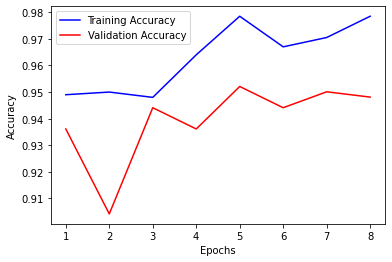

In [305]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(train_acc)+1, 1),
         train_acc,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , len(val_acc)+1, 1),
         val_acc, 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [306]:
#prediction 
test_pred = model.predict(X_test)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

16/16 [==============================] - 28s 2s/step


In [307]:
test_pred_array = np.array(test_pred_class)
pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,435,9
1,15,42


In [308]:
print(classification_report_imbalanced(y_test, test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.74      0.97      0.85      0.74       444
          1       0.82      0.74      0.98      0.78      0.85      0.70        57

avg / total       0.95      0.95      0.76      0.95      0.85      0.74       501



In [309]:
test_pred

array([[1.15367575e-05],
       [1.17114792e-02],
       [1.69426428e-07],
       [3.38532001e-04],
       [1.03108912e-04],
       [2.07627556e-04],
       [5.48843054e-05],
       [9.80659842e-01],
       [5.12010492e-02],
       [1.00038864e-03],
       [6.51329696e-01],
       [4.87089790e-02],
       [1.43134330e-05],
       [1.78460577e-05],
       [1.18413819e-02],
       [5.58255672e-01],
       [2.80445725e-01],
       [9.72218871e-01],
       [9.36534263e-07],
       [4.57386859e-03],
       [1.27876829e-05],
       [4.52277072e-06],
       [2.25023436e-03],
       [1.86368652e-05],
       [6.85590599e-03],
       [4.92814451e-01],
       [1.78813192e-04],
       [3.61008316e-01],
       [8.07500109e-02],
       [6.37277495e-04],
       [3.53505015e-01],
       [7.95331958e-04],
       [1.04242668e-03],
       [7.47714648e-06],
       [2.12030471e-04],
       [3.50977108e-02],
       [6.62023297e-07],
       [7.14252064e-06],
       [9.99328852e-01],
       [4.88345628e-04],


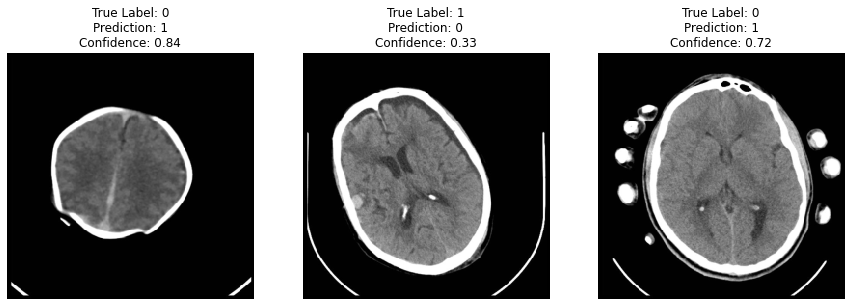

In [310]:
error_indexes = []
for i in range(len(test_pred)):
    if(test_pred_class[i] != y_test[i]):
        error_indexes += [i]

plt.figure(figsize=(15,8))        
        
j = 1
for i in np.random.choice(error_indexes, size = 3):
    img = X_test[i]
    
    plt.subplot(1, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + str(y_test[i]) \
              + '\n' + 'Prediction: '+ str(test_pred_class[i]) \
              + '\n' + 'Confidence: '+ str(round(test_pred[i][0], 2)))

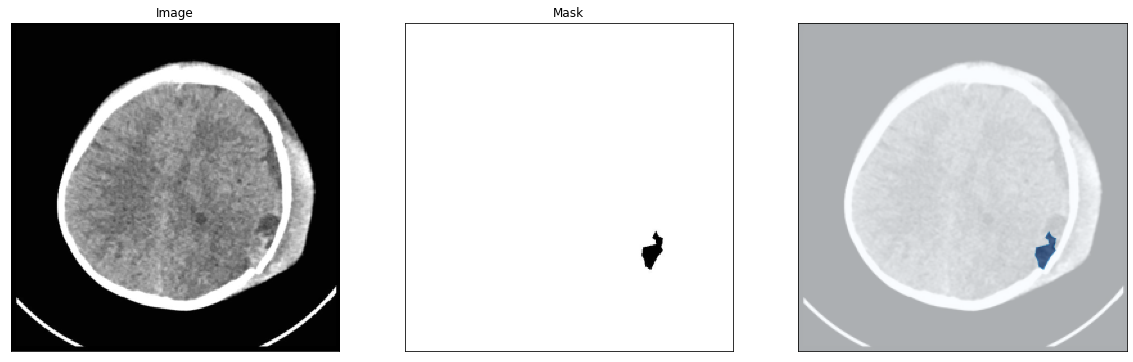

In [311]:
last_conv_layer_name = "top_conv"

# affichage d'une image aléatoire avec hémorragie
from random import randint

img = X_brain[y_brain == 1][12]
mask = X_mask[y_brain == 1][12]
#plt.imshow(img[randint(0,len(img))],cmap = cm.binary, interpolation='None')
#plt.imshow(img,cmap = cm.binary, interpolation='None')
#plt.imshow(mask,cmap = cm.binary, interpolation='None')

# affichage des images côte à côte
fig = plt.figure(figsize = (20,20))

fig.add_subplot(1,3,1)
plt.imshow(img,cmap = cm.binary, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.title('Image')

fig.add_subplot(1,3,2)
plt.imshow(mask,cmap = cm.binary, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.imshow(mask, cmap='Blues', alpha=0.7)

plt.show();

In [312]:
#algorithme de Grad CAM

def get_img_array(img):
    # `img` is a PIL image of size 299x299
    #img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    #array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(img, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 131ms/step
Predicted: 0


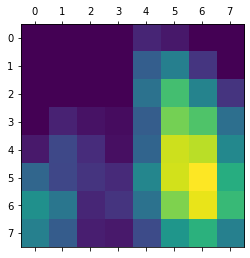

In [313]:
# Prepare image
img_array = preprocess_input(get_img_array(img))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", np.argmax(preds[0]))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

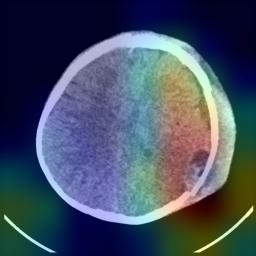

In [314]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(256 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img, heatmap)